# Neural Networks in ``PyTorch``: transfer learning

The **Fsshion MNIST dataset** consists of 60,000 images of clothes, where each image has size 28X28. There are 10 different classes of clothes:<br>
0: T-shirt/top<br>
1: Trouser<br>
2: Pullover<br>
3: Dress<br>
4: Coat<br>
5: Sandal<br>
6: Shirt<br>
7: Sneaker<br>
8: Bag<br>
9: Ankle boot

<img src="files/figures/fashion_mnist.png" width="500px"/>

Now, we will download a **convoultional neural network** called **ResNet** that has already been **pre-trained** on a large dataset of images. Next, we will **fine-tune** (i.e. re-train) ResNet on the Fashion MNIST dataset.

During pre-training, ResNet has acquired knowledge that can be applied to the learning of the downstream task. This process, very important in Machine Learning, is referred to as **transfer learning (TL)**.

MNIST dataset. This is a **classification problem**.<br>

The definition and training of a neural network invoves the following steps:

0. Import **librairies**;
1. Get the **datasets** (train, validation and test);
2. Define the **dataloaders** from the datasets (train and test);
3. Define the **model**;
4. Define the **loss function**;
5. Define the **optimizer**;
7. **Train** the model (training loop);
8. Get the **results** (predict).

## 0. Librairies

In [54]:
import os

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, random_split
import torchvision.models as models
import torchvision.datasets as datasets
from torchvision.transforms import ToTensor

from sklearn.metrics import classification_report

import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

## 1. Datasets

- Load the train and test Fashion MNIST datasets using the following commands:<br>
```
train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=ToTensor())
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=ToTensor())
```
Each sample consists of a tensor (the image encoded in black and white), and a label (the digit that it represents).

- Examine the data (structure, dimension, etc).
- Create a function to visualize some data as an image.

In [55]:
train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=ToTensor())
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=ToTensor())

In [56]:
train_dataset, val_dataset = random_split(train_dataset, [50000,10000])

In [57]:
len(train_dataset), len(val_dataset), len(test_dataset)

(50000, 10000, 10000)

In [58]:
# Each sample data is a tuple: tensor [1, 28, 28], label
train_dataset[0][0].shape, train_dataset[0][1]

(torch.Size([1, 28, 28]), 4)

In [59]:
def display_data(sample):
    
    # get tensor and label
    tensor, label = sample[0], sample[1]
    tensor = tensor.view(28, 28) # reshape into 28 x 28
    
    # plot
    plt.figure(figsize=(2, 2))
    plt.title(f'label: {label}')
    plt.imshow(tensor)
    plt.show()

In [60]:
def display_some_data(dataset):
    
    fig, axs = plt.subplots(5, 5, figsize=(10,10))
    
    for i in range(25):
        
        tensor, label = dataset[i][0], dataset[i][1]
        
        axs[i//5, i%5].set_title(f"Label: {label}")
        axs[i//5, i%5].imshow(tensor.view(28, 28))
    
    plt.show()

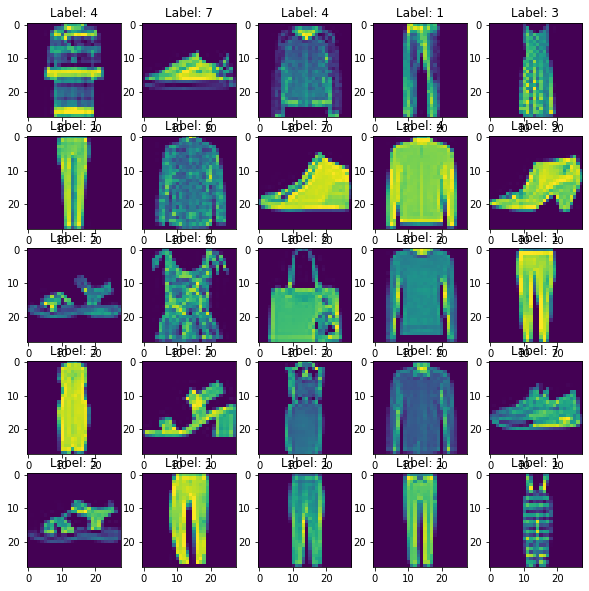

In [61]:
display_some_data(train_dataset)

## 2. Dataloaders

A **dataloader** creates batches of samples from a dataset so that they can be passed into a model.
- Create a train and test dataloaders using the following commands:
```
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)
```
- Note that dataloaders are not subscriptable.
- Try to catch one batch of the dataloader and examine it.

In [62]:
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)

## 3. Model

- Define and instanciate a **ResNet convolutional neural network** where the output layer is modified to fit predict the 10 different classes of Fashion MNIST.

    The ResNet network is available from the ``torchvision`` library via the following command:<br> ``torchvision.models.resnet50(pretrained=True)``

In [63]:
class CustomResNet(nn.Module):
    
    def __init__(self, in_channels=1):
        
        super(CustomResNet, self).__init__()

        self.model = models.resnet50(pretrained=True) # ResNet pretrained

        # Modify input layer for 1-channel (grayscale) instead of 3-channel (RGB) images. 
        # self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)  # original
        self.model.conv1 = nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)

        # Modify output layer for 10 instead of 1000 classes
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Linear(num_ftrs, 10)

    def forward(self, x):
        
        return self.model(x)

In [64]:
network = CustomResNet()

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [65]:
# Put network to GPU if exists
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
network.to(device)

CustomResNet(
  (model): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
       

## 4. Loss

- Define a **cross entropy loss** with the following command:<br>
```
loss = nn.CrossEntropyLoss()
```
- Try to understand this loss object:<br>
https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html

In [66]:
loss = nn.CrossEntropyLoss()

## 5. Optimizer

- Define an **SGD optimizer** with the following command:<br>
```
optimizer = torch.optim.SGD(network.parameters(), lr=0.005)
```
- Try to understand this object:<br>
https://pytorch.org/docs/stable/generated/torch.optim.SGD.html#torch.optim.SGD

In [67]:
optimizer = torch.optim.SGD(network.parameters(), lr=0.001)

## 6. Training

- Define a **training loop** for you model.
- The key instructions are:
    - ``optimizer.zero_grad()``: reset gradients to 0
    - ``loss.backward()``      : compute new gradients
    - ``optimizer.step()``     : uptdate weights
- Train the model for 10 epochs only (because of **transfer learning!**).
- Plot the training loss.

In [68]:
def train(model, loss=None, optimizer=None, train_dataloader=None, val_dataloader=None, nb_epochs=10):
    """Training loop"""

    min_val_loss = torch.inf
    train_losses = []
    val_losses = []

    # Iterrate over epochs
    for e in range(nb_epochs):

        # Training
        train_loss = 0.0

        for data, labels in train_dataloader:

            # Transfer data to GPU if available
            if torch.cuda.is_available():
                data, labels = data.cuda(), labels.cuda()
            
            # Reset gradients to 0
            optimizer.zero_grad()

            # Forward Pass
            targets = model(data)

            # Compute training loss
            current_loss = loss(targets, labels)
            train_loss += current_loss.item()

            # Compute gradients
            current_loss.backward()

            # Update weights
            optimizer.step()
        
        # Validation
        val_loss = 0.0

        # Put model in eval mode
        model.eval()

        for data, labels in val_dataloader:

            # Transfer data to GPU if available
            if torch.cuda.is_available():
                data, labels = data.cuda(), labels.cuda()

            # Forward Pass
            targets = model(data)

            # Compute validation loss
            current_loss = loss(targets, labels)
            val_loss += current_loss.item()
        
        # Prints
        print(f"Epoch {e+1}/{nb_epochs} \
                \t Training Loss: {train_loss/len(train_dataloader):.3f} \
                \t Validation Loss: {val_loss/len(val_dataloader):.3f}")
        
        train_losses.append(train_loss/len(train_dataloader))
        val_losses.append(val_loss/len(val_dataloader))

        # Save model if val loss decreases
        if val_loss < min_val_loss:

            min_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pt')
            
    return train_losses, val_losses

In [69]:
# takes a long time if not on GPU...
train_losses, val_losses = train(model=network, loss=loss, optimizer=optimizer, 
                                 train_dataloader=train_dataloader, val_dataloader=val_dataloader, 
                                 nb_epochs=10)

Epoch 1/10                 	 Training Loss: 1.018                 	 Validation Loss: 0.574
Epoch 2/10                 	 Training Loss: 0.508                 	 Validation Loss: 0.489
Epoch 3/10                 	 Training Loss: 0.411                 	 Validation Loss: 0.449
Epoch 4/10                 	 Training Loss: 0.357                 	 Validation Loss: 0.412
Epoch 5/10                 	 Training Loss: 0.319                 	 Validation Loss: 0.360
Epoch 6/10                 	 Training Loss: 0.288                 	 Validation Loss: 0.365
Epoch 7/10                 	 Training Loss: 0.261                 	 Validation Loss: 0.440
Epoch 8/10                 	 Training Loss: 0.238                 	 Validation Loss: 0.388
Epoch 9/10                 	 Training Loss: 0.214                 	 Validation Loss: 0.352
Epoch 10/10                 	 Training Loss: 0.193                 	 Validation Loss: 0.387


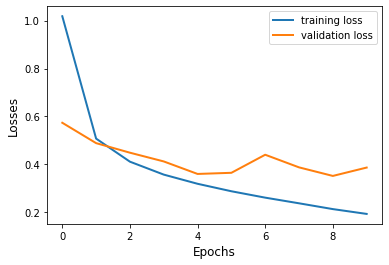

In [71]:
# Plot losses
plt.plot(range(len(train_losses)), train_losses, 
         linewidth=2.0, 
         label='training loss')

plt.plot(range(len(val_losses)), val_losses, 
         linewidth=2.0, 
         label='validation loss')

plt.xlabel("Epochs", size=12)
plt.ylabel("Losses", size=12)
plt.legend()

# plt.savefig('figures/losses.pdf') 
plt.show()

## 6. Testing

- Write a ``predict`` function
    - use ``with torch.no_grad():``
- Compute the accuracy and classification report of the train and test sets.

In [72]:
def predict(model, test_dataloader):

    labels_l = []
    preds_l = []
    
    # Put model in eval mode
    model.eval()
    
    # Testing loop
    with torch.no_grad():
        
        for i, batch in enumerate(test_dataloader):
            
            data, labels = batch
            data = data.to(device)
            labels_l.extend(labels.tolist())
            
            preds = model(data)
            preds = torch.argmax(preds, dim=1)
            preds_l.extend(preds.tolist())
    
    return labels_l, preds_l

In [73]:
train_labels, train_preds = predict(network, train_dataloader)
test_labels, test_preds = predict(network, test_dataloader)

In [74]:
print(classification_report(train_labels, train_preds, digits=4))

              precision    recall  f1-score   support

           0     0.8694    0.9451    0.9056      4987
           1     0.9970    0.9931    0.9951      5085
           2     0.7870    0.9509    0.8612      5048
           3     0.9621    0.9242    0.9428      4974
           4     0.9281    0.8020    0.8605      5005
           5     0.9982    0.9716    0.9847      5000
           6     0.8651    0.7647    0.8118      4973
           7     0.9336    0.9956    0.9636      4958
           8     0.9952    0.9932    0.9942      5023
           9     0.9956    0.9557    0.9752      4947

    accuracy                         0.9298     50000
   macro avg     0.9331    0.9296    0.9295     50000
weighted avg     0.9331    0.9298    0.9295     50000



In [75]:
print(classification_report(test_labels, test_preds, digits=4))

              precision    recall  f1-score   support

           0     0.7616    0.8560    0.8060      1000
           1     0.9897    0.9610    0.9751      1000
           2     0.6831    0.8730    0.7665      1000
           3     0.8930    0.8600    0.8762      1000
           4     0.8473    0.6990    0.7660      1000
           5     0.9830    0.9270    0.9542      1000
           6     0.6836    0.5790    0.6270      1000
           7     0.8900    0.9790    0.9324      1000
           8     0.9747    0.9630    0.9688      1000
           9     0.9709    0.9330    0.9516      1000

    accuracy                         0.8630     10000
   macro avg     0.8677    0.8630    0.8624     10000
weighted avg     0.8677    0.8630    0.8624     10000



## 7. Save

- Save your trained model.
- Try to reload it and see if it works.
- Use the following instructions
```
torch.save(model.state_dict(), <path>)
...
network_2.load_state_dict(torch.load(<path>))
network_2.eval()
```

In [76]:
cwd = os.getcwd()
path = os.path.join(cwd, "model.pt")
path_2 = os.path.join(cwd, "best_model.pt")

In [77]:
# Save last model
torch.save(network.state_dict(), path) 

In [78]:
# Load best model
network_2 = CustomResNet()

network_2.load_state_dict(torch.load(path))
network_2.eval()
network_2.to(device)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


CustomResNet(
  (model): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
       

In [79]:
test_labels, test_preds = predict(network_2, test_dataloader)

In [80]:
print(classification_report(test_labels, test_preds))

              precision    recall  f1-score   support

           0       0.76      0.86      0.81      1000
           1       0.99      0.96      0.98      1000
           2       0.68      0.87      0.77      1000
           3       0.89      0.86      0.88      1000
           4       0.85      0.70      0.77      1000
           5       0.98      0.93      0.95      1000
           6       0.68      0.58      0.63      1000
           7       0.89      0.98      0.93      1000
           8       0.97      0.96      0.97      1000
           9       0.97      0.93      0.95      1000

    accuracy                           0.86     10000
   macro avg       0.87      0.86      0.86     10000
weighted avg       0.87      0.86      0.86     10000

